In [1]:
# need to install this manually (since it is not on the pangeo notebook image)
# !mamba install xmip -y

In [2]:
# import xmip
# xmip.__version__

In [3]:
import dask
from distributed import LocalCluster, Client

dask.config.set(**{"distributed.dashboard.link": "/user/{JUPYTERHUB_USER}/proxy/{port}/status"})
cluster = LocalCluster(n_workers=1)
client = Client(cluster)
client

2022-07-11 23:49:07,731 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/presentation_scipy22_cmip/dask-worker-space/worker-1qr2e564', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 58.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35965,Workers: 1
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.88 GiB
Comm: tcp://127.0.0.1:45735,Total threads: 16
Dashboard: /user/jbusecke/proxy/36493/status,Memory: 58.88 GiB
Nanny: tcp://127.0.0.1:37689,


In [4]:
from xmip.preprocessing import combined_preprocessing
from xmip.postprocessing import match_metrics, pick_first_member
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from xarrayutils.plotting import shaded_line_plot

from functools import reduce
from tqdm.auto import tqdm
import xarray as xr
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [5]:
def _maybe_make_list(a):
    if isinstance(a,str):
        return [a]
    else:
        return a

def search_and_load_zarr(df, preprocess=combined_preprocessing, **kwargs):
    # parse kwargs to dataframe index list
    filter_list = [df[k].isin(_maybe_make_list(v)) for k,v in kwargs.items()]
    index = reduce(lambda a,b: a & b, filter_list, True)
    df_filtered = df.loc[index]
    stores = df_filtered['zstore'].tolist()
    instance_ids = ['.'.join(s.split('/')[3:-1]) for s in stores]
    ddict = {}
    iter_list = list(zip(instance_ids, stores))
    for iid, sto in tqdm(iter_list):
        try:
            ds = xr.open_zarr(sto, consolidated=True, use_cftime=True)
            # ds = xr.open_dataset(sto, engine='zarr', consolidated=True, use_cftime=True, chunks={'time':3})
            if preprocess:
                ds = preprocess(ds)
            ddict[iid] = ds
        except Exception as e:
            print(f"{iid} failed with {e}")
    return ddict

df = pd.read_csv("https://storage.googleapis.com/cmip6/pangeo-cmip6.csv")

In [18]:
# choosing a subset of models (to reduce the compute time, and some unresolved issues)
# The commented models have many members and increase the loading time significantly
source_ids = [
 # 'ACCESS-ESM1-5',
 'CAS-ESM2-0',
 'CMCC-ESM2',
 # 'CNRM-ESM2-1',
 'E3SM-1-1-ECA',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-ESM4',
 'ICON-ESM-LR',
 'INM-CM5-0',
 # 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'KIOST-ESM',
 'MCM-UA-1-0',
 # 'MIROC6',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-MM',
 'SAM0-UNICON',
 'TaiESM1',
]

grid_labels = ['gn']
activity_ids = ['CMIP', 'ScenarioMIP']
experiment_ids = [
        'historical',
        'ssp126',
        'ssp245',
        'ssp370',
        'ssp585',
    ]

data = search_and_load_zarr(
    df,
    source_id=source_ids,
    variable_id='tos',
    activity_id = activity_ids,
    experiment_id=experiment_ids,
    table_id='Omon',
    grid_label='gn',
)
area_data = search_and_load_zarr(
    df,
    source_id=source_ids,
    experiment_id = experiment_ids + ['piControl'],
    variable_id='areacello',
    table_id='Ofx',
    grid_label='gn',
)

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

## xMIP: Match cell area to datasets

In [19]:
data_with_metrics = match_metrics(
    data,
    area_data,
    ['areacello'],
    print_statistics=True
)

Processed 138 datasets.
Exact matches:{'areacello': 0}
Other matches:{'areacello': 138}
No match found:{'areacello': 0}


## xMIP: Pick only one member to speed things up

In [20]:
data_first = pick_first_member(data_with_metrics)

## Create averaged timeseries

In [21]:
data_timeseries = {}
for k,ds in data_first.items():
    
    print(k)
    # This is the core of the analysis. A one-liner thanks to xarray. 
    timeseries = ds.tos.weighted(ds.areacello.fillna(0)).mean(['x', 'y']).load()
    
    timeseries.attrs = {k:v for k,v in ds.attrs.items()}
    data_timeseries[k] = timeseries

GFDL-ESM4.gn.historical.Omon.tos
GFDL-CM4.gn.ssp245.Omon.tos
GFDL-CM4.gn.historical.Omon.tos
GFDL-ESM4.gn.ssp585.Omon.tos
GFDL-ESM4.gn.ssp245.Omon.tos
GFDL-ESM4.gn.ssp370.Omon.tos
GFDL-ESM4.gn.ssp126.Omon.tos
GFDL-CM4.gn.ssp585.Omon.tos
SAM0-UNICON.gn.historical.Omon.tos
MPI-ESM1-2-LR.gn.ssp245.Omon.tos
MPI-ESM1-2-LR.gn.ssp126.Omon.tos
MPI-ESM1-2-LR.gn.historical.Omon.tos
MPI-ESM1-2-LR.gn.ssp585.Omon.tos
MPI-ESM1-2-LR.gn.ssp370.Omon.tos
MCM-UA-1-0.gn.historical.Omon.tos
MCM-UA-1-0.gn.ssp585.Omon.tos
MCM-UA-1-0.gn.ssp126.Omon.tos
MCM-UA-1-0.gn.ssp245.Omon.tos
MCM-UA-1-0.gn.ssp370.Omon.tos
MRI-ESM2-0.gn.historical.Omon.tos
MRI-ESM2-0.gn.ssp245.Omon.tos
MRI-ESM2-0.gn.ssp370.Omon.tos
FGOALS-g3.gn.historical.Omon.tos
MRI-ESM2-0.gn.ssp126.Omon.tos
MRI-ESM2-0.gn.ssp585.Omon.tos
NorESM2-MM.gn.ssp126.Omon.tos
NorESM2-MM.gn.ssp245.Omon.tos
NorESM2-MM.gn.ssp585.Omon.tos
NorESM2-MM.gn.ssp370.Omon.tos
NorESM2-MM.gn.historical.Omon.tos
FGOALS-g3.gn.ssp245.Omon.tos
FGOALS-g3.gn.ssp126.Omon.tos
FGOALS

## Concatenate experiments into xarray datasets

In [22]:
# debug version
timeseries_hist_datasets = []
timeseries_ssp126_datasets = []
timeseries_ssp245_datasets = []
timeseries_ssp370_datasets = []
timeseries_ssp585_datasets = []

for k,ds in data_timeseries.items():
    # Separate experiments
    out = ds.convert_calendar('standard')
    out = out.sel(time=slice('1850', '2100'))# cut extended runs
    out = out.assign_coords(source_id=ds.source_id)
    if ds.experiment_id == 'historical':
        # CMIP
        if len(out.time)==1980:
            timeseries_hist_datasets.append(out)
        else:
            print(f"found {len(ds.time)} for {k}")
    else:
        #scenarioMIP
        if len(out.time)!=1032:
            print(f"found {len(out.time)} for {k}")
            # print(ds.time)
        else:
            if ds.experiment_id == 'ssp126':
                timeseries_ssp126_datasets.append(out)
            elif ds.experiment_id == 'ssp245':
                timeseries_ssp245_datasets.append(out)
            elif ds.experiment_id == 'ssp370':
                timeseries_ssp370_datasets.append(out)
            elif ds.experiment_id == 'ssp585':
                timeseries_ssp585_datasets.append(out)            

concat_kwargs = dict(
    dim='source_id',
    join='override',
    compat='override',
    coords='minimal'
) 
timeseries_hist = xr.concat(timeseries_hist_datasets, **concat_kwargs)
timeseries_ssp126 = xr.concat(timeseries_ssp126_datasets, **concat_kwargs)
timeseries_ssp245 = xr.concat(timeseries_ssp245_datasets, **concat_kwargs)
timeseries_ssp370 = xr.concat(timeseries_ssp370_datasets, **concat_kwargs)
timeseries_ssp585 = xr.concat(timeseries_ssp585_datasets, **concat_kwargs)

## Calculate anomaly to base period (1950-1980)

In [23]:
base_period = timeseries_hist.sel(time=slice('1950','1980')).mean('time')
smoothing_window = 12*2 # higher than IPCC to compensate for missing member mean

hist = (timeseries_hist - base_period).rolling(time=smoothing_window).mean()
ssp126 = (timeseries_ssp126 - base_period).rolling(time=smoothing_window).mean()
ssp245 = (timeseries_ssp245 - base_period).rolling(time=smoothing_window).mean()
ssp370 = (timeseries_ssp370 - base_period).rolling(time=smoothing_window).mean()
ssp585 = (timeseries_ssp585 - base_period).rolling(time=smoothing_window).mean()

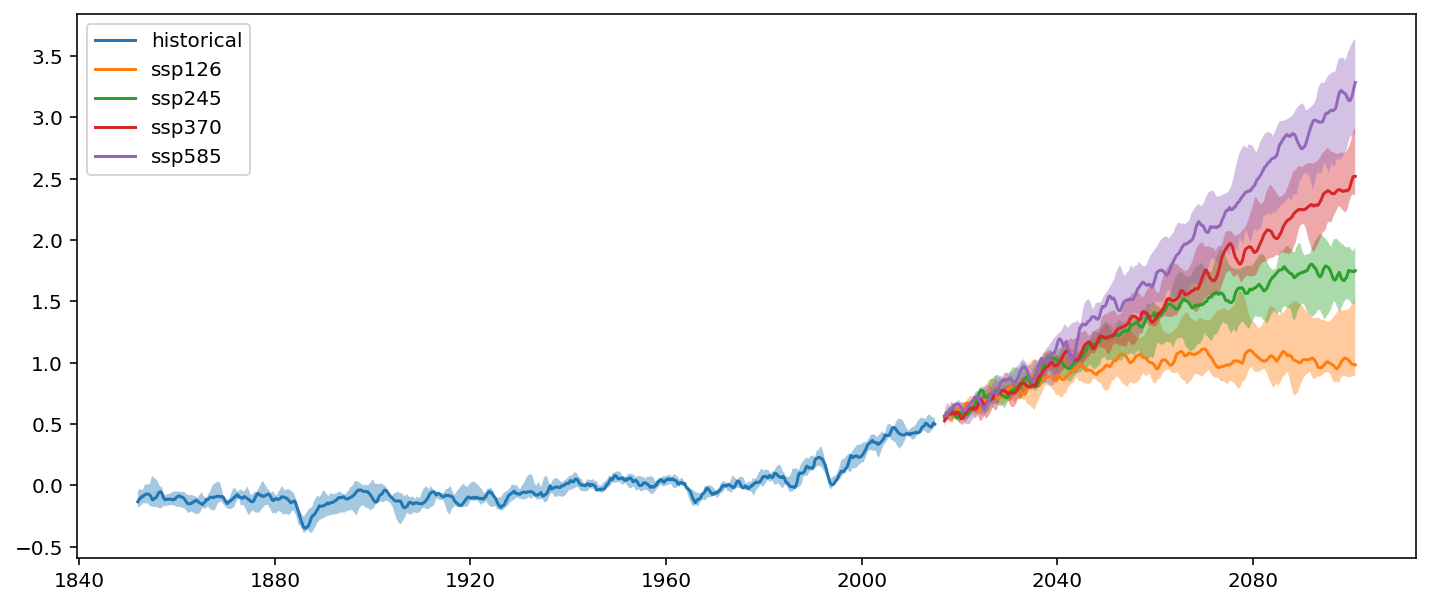

In [24]:
%matplotlib inline
plot_kwargs = dict(spread_style='quantile', spreads=[0.5])

plt.figure(figsize=[12,5])

shaded_line_plot(hist, 'source_id', **plot_kwargs, line_kwargs=dict(label='historical'))
shaded_line_plot(ssp126, 'source_id', **plot_kwargs, line_kwargs=dict(label='ssp126'))
shaded_line_plot(ssp245, 'source_id', **plot_kwargs, line_kwargs=dict(label='ssp245'))
shaded_line_plot(ssp370, 'source_id', **plot_kwargs, line_kwargs=dict(label='ssp370'))
shaded_line_plot(ssp585, 'source_id', **plot_kwargs, line_kwargs=dict(label='ssp585'))
plt.legend()